In [15]:
import numpy as np
import pandas as pd
import re

from collections import Counter
import string

import re
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, InputLayer, Bidirectional, TimeDistributed, Embedding, Dropout
from keras.layers import Input
from keras.optimizers import Adam
from keras.models import load_model
from keras.losses import CategoricalCrossentropy
from keras.losses import SparseCategoricalCrossentropy
from keras import Model

from tf2crf import CRF
from tf2crf import CRF, ModelWithCRFLoss


#from keras_contrib.layers import CRF
# from sklearn_crfsuite import CRF
#from keras_contrib.losses import crf_loss
#from keras_contrib.metrics import crf_viterbi_accuracy

from konlpy.tag import Kkma
from konlpy.tag import Mecab
from konlpy.utils import pprint
from konlpy.tag import Twitter,Okt

from transformers import BertModel
# from tokenization_kobert import KoBertTokenizer

import os

from tqdm import tqdm

import matplotlib.pyplot as plt
import plotly.express as px


from keras.callbacks import Callback
from keras.utils.vis_utils import plot_model
from seqeval.metrics import f1_score, classification_report

In [2]:
def NER_generator(df):
    df["IOB"] = df["IOB"].fillna("O")
    df["rule_label"] = df.rule_label.replace("O","")
    df["NER"] = df["IOB"] + "-" + df["rule_label"]
    df["NER"] = df.NER.replace("O-","O")
    return df

In [3]:
def IOB_insert(df_):
    for i in range(10):
        index_ = []
        for i in range(len(df_)):
            a = df_.loc[i,"IOB"]
            if a == "I":
                b = df_.loc[i-1,"IOB"]
                if b == "O":
                    index_.append(i-1)
                    #print(i-1)
        if len(index_) ==0:
            break
        for i in index_:
            df_.loc[i,"IOB"] = "I"
        print("---------------------------")
    return df_

In [4]:
class F1score(Callback):
    def __init__(self, value = 0.0, use_char=True ):
        super(F1score, self).__init__()
        self.value = value
        self.use_char = use_char

    def sequences_to_tags(self, sequences): # 예측값을 index_to_ner를 사용하여 태깅 정보로 변경하는 함수.
        result = []
        for sequence in sequences: # 전체 시퀀스로부터 시퀀스를 하나씩 꺼낸다.
            tag = []
            for pred in sequence: # 시퀀스로부터 예측값을 하나씩 꺼낸다.
                pred_index = np.argmax(pred) # 예를 들어 [0, 0, 1, 0 ,0]라면 1의 인덱스인 2를 리턴한다.
                tag.append(index_to_ner[pred_index].replace("PAD", "O")) # 'PAD'는 'O'로 변경
            result.append(tag)
        return result

    # 에포크가 끝날 때마다 실행되는 함수
    def on_epoch_end(self, epoch, logs={}):
        print(self.validation_data)

In [5]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(12,12))
    #plt.plot()
    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('accuracy')
    plt.plot(hist['epoch'], hist['accuracy'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_val_accuracy'],
           label = 'Val Error')
    plt.ylim([0.6,1])
    plt.title("Accuracy")
    plt.legend()
    
    plt.subplot(2,1,2)
    plt.xlabel('Epoch')
    plt.ylabel('accuracy')
    plt.plot(hist['epoch'], hist['crf_loss'],
           label='Train loss')
    plt.plot(hist['epoch'], hist['val_crf_loss_val'],
           label = 'Val loss')
    #plt.ylim([0.6,1])
    plt.title("Loss")
    plt.legend()
    
    plt.show()
    return hist

def plot_history2(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(12,12))
    #plt.plot()
    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('accuracy')
    plt.plot(hist['epoch'], hist['accuracy'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_accuracy'],
           label = 'Val Error')
    plt.ylim([0.6,1])
    plt.title("Accuracy")
    plt.legend()
    
    plt.subplot(2,1,2)
    plt.xlabel('Epoch')
    plt.ylabel('accuracy')
    plt.plot(hist['epoch'], hist['loss'],
           label='Train loss')
    plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val loss')
    #plt.ylim([0.6,1])
    plt.title("Loss")
    plt.legend()
    
    plt.show()
    return hist


In [26]:
path_ = r"C:\Users\Samsung\jupyter\Project_Deep_learning_2020\data\NER"
file_list = os.listdir(path_)
file_list_xlsx = [f for f in file_list if f.endswith(".csv")]
airpro = pd.read_csv(r"C:\Users\Samsung\jupyter\Project_Deep_learning_2020\data\NER\airpro.csv",index_col = 0)
buds = pd.read_csv(r"C:\Users\Samsung\jupyter\Project_Deep_learning_2020\data\NER\buds.csv",index_col = 0)
airpro = NER_generator(airpro)
buds = NER_generator(buds)
buds_in = IOB_insert(buds)
airpro_in = IOB_insert(airpro)

---------------------------
---------------------------
---------------------------
---------------------------
---------------------------
---------------------------
---------------------------
---------------------------
---------------------------
---------------------------
---------------------------
---------------------------
---------------------------
---------------------------


In [27]:
data_ = airpro_in
elw = data_.groupby('enter').count()
iqr = elw['word'].describe()
elw = data_.groupby('enter').count()
slw = data_.groupby('sentence').count()
length = data_['enter'].unique()
func = lambda temp: [(w, t) for w, t in zip(temp["word"].values.tolist(), temp["NER"].values.tolist())]
tagged_sentences=[t for t in data_.groupby("enter").apply(func)]
sentences, ner_tags = [], [] 
for tagged_sentence in tagged_sentences: # 47,959개의 문장 샘플을 1개씩 불러온다.
    sentence, tag_info = zip(*tagged_sentence) # 각 샘플에서 단어들은 sentence에 개체명 태깅 정보들은 tag_info에 저장.
    sentences.append(list(sentence)) # 각 샘플에서 단어 정보만 저장한다.
    ner_tags.append(list(tag_info)) # 각 샘플에서 개체명 태깅 정보만 저장한다.

In [28]:
src_tokenizer = Tokenizer(oov_token='OOV') # 모든 단어를 사용하지만 인덱스 1에는 단어 'OOV'를 할당한다.
src_tokenizer.fit_on_texts(sentences)
tar_tokenizer = Tokenizer(lower=False) # 태깅 정보들은 내부적으로 대문자를 유지한채로 저장
tar_tokenizer.fit_on_texts(ner_tags)

In [29]:
vocab_size = len(src_tokenizer.word_index) + 1
tag_size = len(tar_tokenizer.word_index) + 1
X = src_tokenizer.texts_to_sequences(sentences)
y= tar_tokenizer.texts_to_sequences(ner_tags)
word_to_index = src_tokenizer.word_index
index_to_word = src_tokenizer.index_word
ner_to_index = tar_tokenizer.word_index
index_to_ner = tar_tokenizer.index_word
index_to_ner[0] = 'PAD'

In [30]:
max_len = 70
# 모든 샘플들의 길이를 맞출 때 뒤의 공간에 숫자 0으로 채움.
X = pad_sequences(X, padding='post', maxlen=max_len)
y = pad_sequences(y, padding='post', maxlen=max_len)

# LSTM

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=777)
y_train = to_categorical(y_train, num_classes=tag_size)
y_test = to_categorical(y_test, num_classes=tag_size)

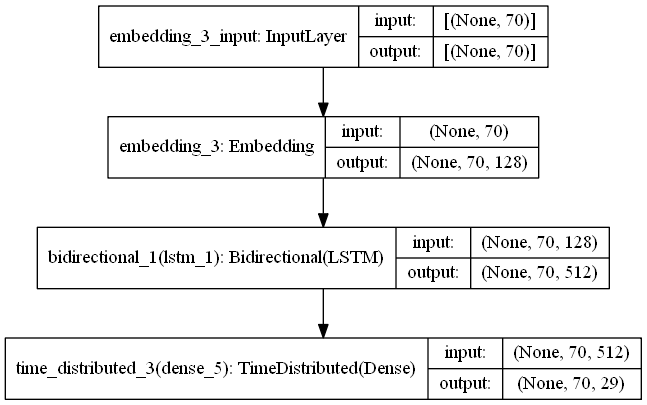

In [32]:
model2 = Sequential()
model2.add(Embedding(vocab_size, 128, input_length=max_len, mask_zero=True))
model2.add(Bidirectional(LSTM(256, return_sequences=True)))
model2.add(TimeDistributed(Dense(tag_size, activation=('softmax'))))
model2.compile(loss='categorical_crossentropy', optimizer=Adam(0.001), metrics=['accuracy'])
plot_model(model2, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [33]:
history2 = model2.fit(X_train, y_train, batch_size=128, epochs=50,  validation_split=0.1)#, callbacks=[F1score(use_char=False)])

Epoch 1/50
5/5 [==============================] - 14s 2s/step - loss: 0.9036 - accuracy: 0.5257 - val_loss: 0.8682 - val_accuracy: 0.9366
Epoch 2/50
5/5 [==============================] - 6s 1s/step - loss: 0.6309 - accuracy: 0.9101 - val_loss: 0.2987 - val_accuracy: 0.9366
Epoch 3/50
5/5 [==============================] - 6s 1s/step - loss: 0.3210 - accuracy: 0.9133 - val_loss: 0.2185 - val_accuracy: 0.9366
Epoch 4/50
5/5 [==============================] - 6s 1s/step - loss: 0.2424 - accuracy: 0.9130 - val_loss: 0.1664 - val_accuracy: 0.9366
Epoch 5/50
5/5 [==============================] - 7s 1s/step - loss: 0.1819 - accuracy: 0.9139 - val_loss: 0.1659 - val_accuracy: 0.9366
Epoch 6/50
5/5 [==============================] - 7s 1s/step - loss: 0.1779 - accuracy: 0.9158 - val_loss: 0.1645 - val_accuracy: 0.9366
Epoch 7/50
5/5 [==============================] - 7s 1s/step - loss: 0.1712 - accuracy: 0.9134 - val_loss: 0.1427 - val_accuracy: 0.9366
Epoch 8/50
5/5 [========================

In [34]:
tf.keras.models.save_model(model2, r'C:\Users\Samsung\jupyter\Project_Deep_learning_2020\data\NER\model\LSTM_2')

INFO:tensorflow:Assets written to: C:\Users\Samsung\jupyter\Project_Deep_learning_2020\data\NER\model\LSTM_2\assets


INFO:tensorflow:Assets written to: C:\Users\Samsung\jupyter\Project_Deep_learning_2020\data\NER\model\LSTM_2\assets


In [35]:
loss_,accu_= model2.evaluate(X_test,y_test)
y_pred = model2.predict(X_test)
accu_

5/5 [==============================] - 1s 201ms/step - loss: 0.0582 - accuracy: 0.9562


0.956154465675354

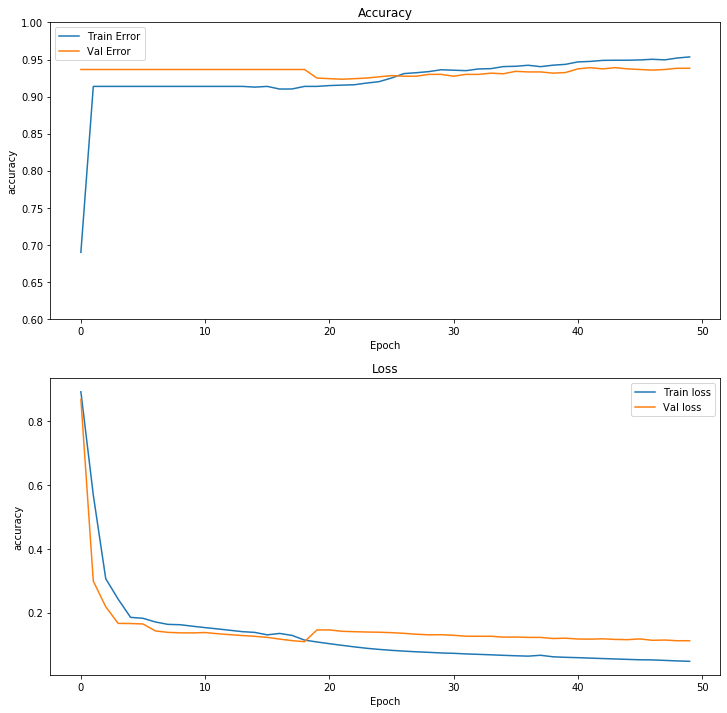

In [36]:
hist2 = plot_history2(history2)

In [37]:
hist2.tail()

,loss,accuracy,val_loss,val_accuracy,epoch
45,0.052429,0.949467,0.117700,0.936573,45
46,0.051963,0.950364,0.113429,0.935750,46
47,0.050438,0.949566,0.114202,0.936573,47
48,0.048845,0.952058,0.112045,0.938221,48
49,0.047564,0.953553,0.112090,0.938221,49


In [41]:
for i in [54,20,100,22,25,147,40]:
    y_predicted = model2.predict(np.array([X_test[i]])) # 입력한 테스트용 샘플에 대해서 예측 y를 리턴
    y_predicted = np.argmax(y_predicted, axis=-1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.
    true = np.argmax(y_test[i], -1) # 원-핫 인코딩을 다시 정수 인코딩으로 변경함.
    print("target: ",i)
    print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
    print(35 * "-")

    for w, t, pred in zip(X_test[i], true, y_predicted[0]):
        if w != 0: # PAD값은 제외함.
            print("{:17}: {:7} {}".format(index_to_word[w], index_to_ner[t], index_to_ner[pred]))
    print("==================================")

target:  54
단어             |실제값  |예측값
-----------------------------------
->               : O       O
오래               : O       O
사용               : O       O
하다               : O       O
조금               : O       O
어지럽다             : B-CVN   O
.                : O       O
저만               : O       O
그렇다              : O       O
있다               : O       O
.                : O       O
그리고              : O       O
걸다               : O       O
다니다              : O       O
때                : O       O
노캔               : B-NC    B-NC
키시               : O       O
면                : O       O
위험하다             : O       O
같다               : O       O
.                : O       O
주변               : B-NC    B-NC
음                : I-NC    I-NC
허용               : O       O
을                : O       O
하다               : O       O
안전하다             : O       O
것                : O       O
같다               : O       O
.                : O       O
target:  20
단어             |실제값  |예측값
---------

In [42]:
f1score = F1score()

y_predicted = model2.predict([X_test])
pred_tags = f1score.sequences_to_tags(y_predicted)
test_tags = f1score.sequences_to_tags(y_test)
print(classification_report(test_tags, pred_tags))

              precision    recall  f1-score   support

          AS       0.00      0.00      0.00         3
         BAT       0.00      0.00      0.00         8
          CA       1.00      0.11      0.20         9
         CAQ       0.00      0.00      0.00         5
         COM       0.00      0.00      0.00         1
         CVN       0.00      0.00      0.00        10
          DE       0.00      0.00      0.00         6
          FA       0.00      0.00      0.00         7
         FIT       0.18      0.46      0.26        13
          NC       0.67      0.67      0.67        42
         PAR       0.25      0.10      0.14        10
          PR       0.13      0.40      0.20         5
          SQ       0.00      0.00      0.00         7

   micro avg       0.40      0.30      0.34       126
   macro avg       0.17      0.13      0.11       126
weighted avg       0.34      0.30      0.28       126



# CRF

In [43]:
X = pad_sequences(X, padding='post', maxlen=max_len)
y = pad_sequences(y, padding='post', maxlen=max_len)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=777)

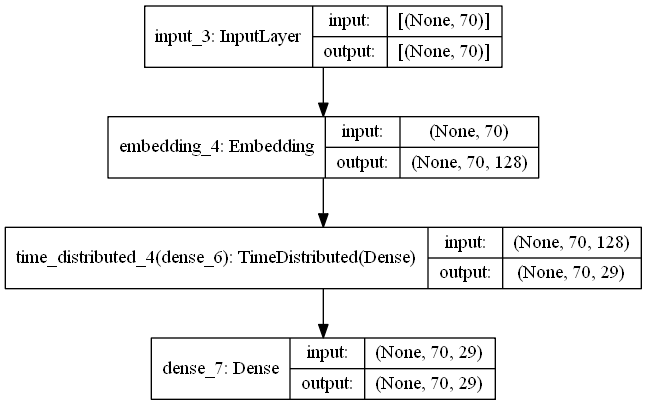

In [44]:

inputs = Input(shape=(70,), dtype='int32')
output = Embedding(vocab_size, 128, input_length=max_len, mask_zero=True)(inputs)
output = TimeDistributed(Dense(tag_size, activation=('softmax')))(output)
output = Dense(tag_size, activation=None)(output)
base_model = Model(inputs, output)
model3 = ModelWithCRFLoss(base_model)
model3.compile(optimizer='adam', metrics=['accuracy'])
plot_model(base_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

C:\Users\Samsung\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\autograph\impl\api.py:390: UserWarning: CRF Decoding does not work with KerasTensors in TF2.4. The bug has since been fixed in tensorflow/tensorflow##45534
  return py_builtins.overload_of(f)(*args)


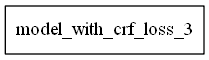

In [45]:
X = pad_sequences(X, padding='post', maxlen=max_len)
y = pad_sequences(y, padding='post', maxlen=max_len)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=777)
inputs = Input(shape=(70,), dtype='int32')
output = Embedding(vocab_size, 128, input_length=max_len, mask_zero=True)(inputs)
output = TimeDistributed(Dense(tag_size, activation=('softmax')))(output)
output = Dense(tag_size, activation=None)(output)
crf = CRF(dtype='float32')
output = crf(output)
base_model = Model(inputs, output)
model3 = ModelWithCRFLoss(base_model)
model3.compile(optimizer='adam', metrics=['accuracy'])
plot_model(model3, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [46]:
history3 = model3.fit(X_train, y_train, batch_size=128, epochs=50,  validation_split=0.1)#, callbacks=[F1score(use_char=False)])

Epoch 1/50
5/5 [==============================] - 4s 349ms/step - crf_loss: 59.7335 - accuracy: 0.0028 - val_crf_loss_val: 70.5773 - val_val_accuracy: 0.0049
Epoch 2/50
5/5 [==============================] - 1s 129ms/step - crf_loss: 63.3585 - accuracy: 0.1048 - val_crf_loss_val: 69.9832 - val_val_accuracy: 0.1812
Epoch 3/50
5/5 [==============================] - 1s 124ms/step - crf_loss: 61.1667 - accuracy: 0.1808 - val_crf_loss_val: 69.3760 - val_val_accuracy: 0.2084
Epoch 4/50
5/5 [==============================] - 1s 132ms/step - crf_loss: 60.1842 - accuracy: 0.2110 - val_crf_loss_val: 68.7571 - val_val_accuracy: 0.2603
Epoch 5/50
5/5 [==============================] - 1s 123ms/step - crf_loss: 72.6329 - accuracy: 0.2488 - val_crf_loss_val: 68.1228 - val_val_accuracy: 0.2619
Epoch 6/50
5/5 [==============================] - 1s 126ms/step - crf_loss: 57.1290 - accuracy: 0.2528 - val_crf_loss_val: 67.4640 - val_val_accuracy: 0.2636
Epoch 7/50
5/5 [==============================] - 1s

In [47]:
tf.keras.models.save_model(model3, r'C:\Users\Samsung\jupyter\Project_Deep_learning_2020\data\NER\model\CRF_2')

C:\Users\Samsung\anaconda3\lib\site-packages\tensorflow_addons\text\crf.py:540: UserWarning: CRF Decoding does not work with KerasTensors in TF2.4. The bug has since been fixed in tensorflow/tensorflow##45534
  "CRF Decoding does not work with KerasTensors in TF2.4. The bug has since been fixed in tensorflow/tensorflow##45534"
C:\Users\Samsung\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\autograph\impl\api.py:390: UserWarning: CRF Decoding does not work with KerasTensors in TF2.4. The bug has since been fixed in tensorflow/tensorflow##45534
  return py_builtins.overload_of(f)(*args)
C:\Users\Samsung\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\autograph\impl\api.py:390: UserWarning: CRF Decoding does not work with KerasTensors in TF2.4. The bug has since been fixed in tensorflow/tensorflow##45534
  return py_builtins.overload_of(f)(*args)
C:\Users\Samsung\anaconda3\lib\site-packages\tensorflow_addons\text\crf.py:540: UserWarning: CRF Decoding does 

INFO:tensorflow:Assets written to: C:\Users\Samsung\jupyter\Project_Deep_learning_2020\data\NER\model\CRF_2\assets


INFO:tensorflow:Assets written to: C:\Users\Samsung\jupyter\Project_Deep_learning_2020\data\NER\model\CRF_2\assets


In [48]:
loss_,accu_= model3.evaluate(X_test,y_test)

accu_

5/5 [==============================] - 0s 25ms/step - crf_loss_val: 30.3314 - val_accuracy: 0.9304


0.9356395602226257

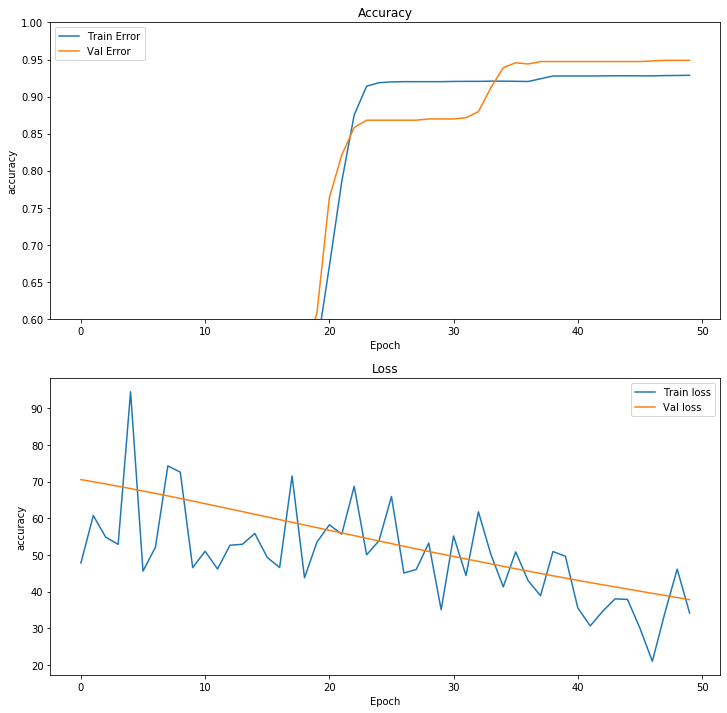

In [50]:
hist3 = plot_history(history3)

In [51]:
hist3.tail()

,crf_loss,accuracy,val_crf_loss_val,val_val_accuracy,epoch
45,30.045757,0.928037,40.119007,0.947282,45
46,20.985977,0.928037,39.539349,0.948105,46
47,34.084686,0.928337,38.973186,0.948929,47
48,46.151463,0.928536,38.394421,0.948929,48
49,34.163368,0.928735,37.800354,0.948929,49


In [53]:
y_pred = model3.predict(X_test)
#i=54 # 확인하고 싶은 테스트용 샘플의 인덱스.
y_pred = model3.predict(X_test)
for i in [54,20,100,22,25,147,40]:
    print("target: ",i)
    print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
    print(35 * "-")

    for w, t, pred in zip(X_test[i], y_test[i], y_pred[0][i]):
        if w != 0: # PAD값은 제외함.
            print("{:17}: {:7} {}".format(index_to_word[w], index_to_ner[t], index_to_ner[pred]))
    print("==================================")

target:  54
단어             |실제값  |예측값
-----------------------------------
->               : O       O
오래               : O       O
사용               : O       O
하다               : O       O
조금               : O       O
어지럽다             : B-CVN   O
.                : O       O
저만               : O       O
그렇다              : O       O
있다               : O       O
.                : O       O
그리고              : O       O
걸다               : O       O
다니다              : O       O
때                : O       O
노캔               : B-NC    O
키시               : O       O
면                : O       O
위험하다             : O       O
같다               : O       O
.                : O       O
주변               : B-NC    O
음                : I-NC    O
허용               : O       O
을                : O       O
하다               : O       O
안전하다             : O       O
것                : O       O
같다               : O       O
.                : O       O
target:  20
단어             |실제값  |예측값
------------------

In [54]:
f1score = F1score()

y_predicted = model3.predict([X_test])
pred_tags = f1score.sequences_to_tags(y_predicted[1])
y_test = to_categorical(y_test, num_classes=tag_size)
test_tags = f1score.sequences_to_tags(y_test)

In [55]:
print(classification_report(test_tags, pred_tags))

              precision    recall  f1-score   support

          AS       0.00      0.00      0.00         3
         BAT       0.00      0.00      0.00         8
          CA       0.00      0.00      0.00         9
         CAQ       0.00      0.00      0.00         5
         COM       0.00      0.00      0.00         1
         CVN       0.00      0.00      0.00        10
          DE       0.00      0.00      0.00         6
          FA       0.00      0.00      0.00         7
         FIT       0.00      0.00      0.00        13
          NC       0.00      0.00      0.00        42
         PAR       0.00      0.00      0.00        10
          PR       0.00      0.00      0.00         5
          SQ       0.00      0.00      0.00         7

   micro avg       0.00      0.00      0.00       126
   macro avg       0.00      0.00      0.00       126
weighted avg       0.00      0.00      0.00       126



C:\Users\Samsung\anaconda3\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Samsung\anaconda3\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# LSTM-CRF

In [56]:
X = pad_sequences(X, padding='post', maxlen=max_len)
y = pad_sequences(y, padding='post', maxlen=max_len)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=777)

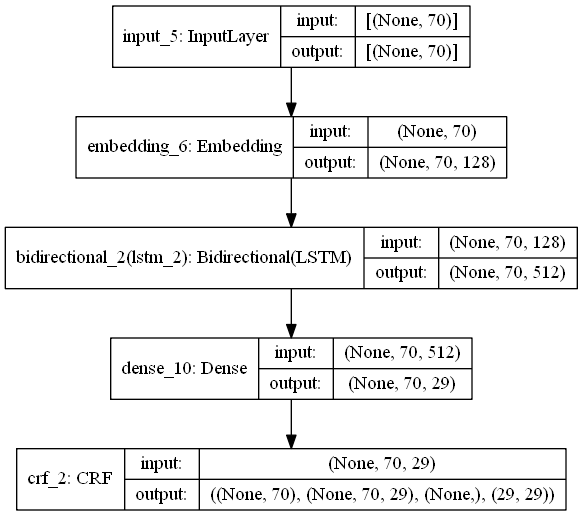

In [57]:
inputs = Input(shape=(70,), dtype='int32')
output = Embedding(vocab_size, 128, input_length=max_len, mask_zero=True)(inputs)
output = Bidirectional(LSTM(256, return_sequences=True))(output)
output = Dense(tag_size, activation=None)(output)
crf = CRF(dtype='float32')
output = crf(output)
base_model = Model(inputs, output)
#model = ModelWithCRFLoss(base_model)
#model.compile(optimizer='adam', metrics=['accuracy'])
plot_model(base_model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

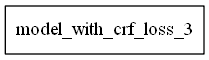

In [58]:
inputs = Input(shape=(70,), dtype='int32')
output = Embedding(vocab_size, 128, input_length=max_len, mask_zero=True)(inputs)
output = Bidirectional(LSTM(256, return_sequences=True))(output)
output = Dense(tag_size, activation=None)(output)
crf = CRF(dtype='float32')
output = crf(output)
base_model = Model(inputs, output)
model = ModelWithCRFLoss(base_model)
model.compile(optimizer='adam', metrics=['accuracy'])
plot_model(model3, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [59]:


history1 = model.fit(X_train, y_train, batch_size=128, epochs=50,  validation_split=0.1)#, callbacks=[F1score(use_char=False)])
loss_,accu_= model.evaluate(X_test,y_test)

accu_

Epoch 1/50
5/5 [==============================] - 19s 2s/step - crf_loss: 54.9704 - accuracy: 0.1456 - val_crf_loss_val: 53.6657 - val_val_accuracy: 0.9308
Epoch 2/50
5/5 [==============================] - 10s 2s/step - crf_loss: 30.8119 - accuracy: 0.9114 - val_crf_loss_val: 20.4534 - val_val_accuracy: 0.9366
Epoch 3/50
5/5 [==============================] - 10s 2s/step - crf_loss: 22.3087 - accuracy: 0.9138 - val_crf_loss_val: 14.8493 - val_val_accuracy: 0.9366
Epoch 4/50
5/5 [==============================] - 10s 2s/step - crf_loss: 13.9990 - accuracy: 0.9138 - val_crf_loss_val: 11.4068 - val_val_accuracy: 0.9366
Epoch 5/50
5/5 [==============================] - 10s 2s/step - crf_loss: 14.0381 - accuracy: 0.9138 - val_crf_loss_val: 11.3830 - val_val_accuracy: 0.9366
Epoch 6/50
5/5 [==============================] - 10s 2s/step - crf_loss: 13.0422 - accuracy: 0.9138 - val_crf_loss_val: 11.1809 - val_val_accuracy: 0.9366
Epoch 7/50
5/5 [==============================] - 10s 2s/step - 

0.954143226146698

In [60]:
tf.keras.models.save_model(model, r'C:\Users\Samsung\jupyter\Project_Deep_learning_2020\data\NER\model\LSTM-CRF_2')

C:\Users\Samsung\anaconda3\lib\site-packages\tensorflow_addons\text\crf.py:540: UserWarning: CRF Decoding does not work with KerasTensors in TF2.4. The bug has since been fixed in tensorflow/tensorflow##45534
  "CRF Decoding does not work with KerasTensors in TF2.4. The bug has since been fixed in tensorflow/tensorflow##45534"
C:\Users\Samsung\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\autograph\impl\api.py:390: UserWarning: CRF Decoding does not work with KerasTensors in TF2.4. The bug has since been fixed in tensorflow/tensorflow##45534
  return py_builtins.overload_of(f)(*args)
C:\Users\Samsung\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\autograph\impl\api.py:390: UserWarning: CRF Decoding does not work with KerasTensors in TF2.4. The bug has since been fixed in tensorflow/tensorflow##45534
  return py_builtins.overload_of(f)(*args)
C:\Users\Samsung\anaconda3\lib\site-packages\tensorflow_addons\text\crf.py:540: UserWarning: CRF Decoding does 

INFO:tensorflow:Assets written to: C:\Users\Samsung\jupyter\Project_Deep_learning_2020\data\NER\model\LSTM-CRF_2\assets


INFO:tensorflow:Assets written to: C:\Users\Samsung\jupyter\Project_Deep_learning_2020\data\NER\model\LSTM-CRF_2\assets


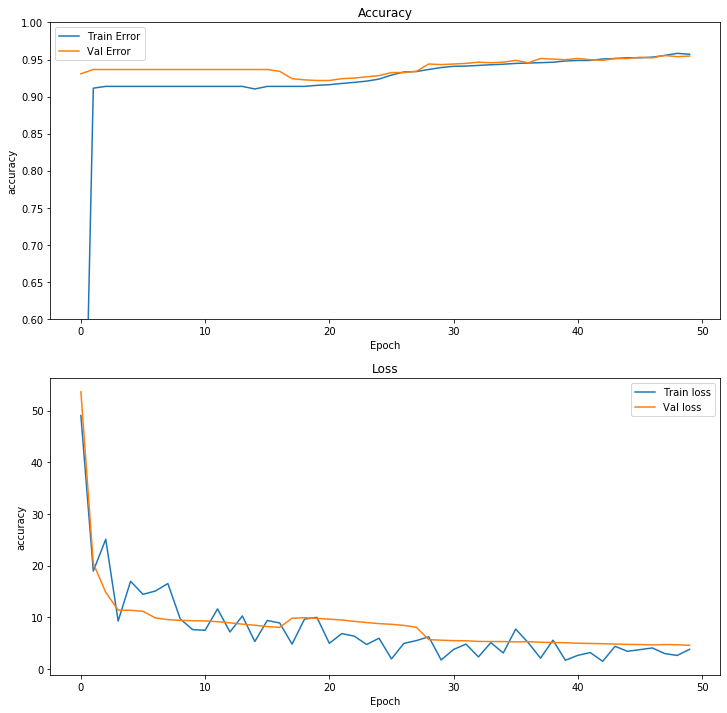

,crf_loss,accuracy,val_crf_loss_val,val_val_accuracy,epoch
0,49.063572,0.145619,53.665710,0.930807,0
1,18.976009,0.911392,20.453371,0.936573,1
2,25.117447,0.913785,14.849339,0.936573,2
3,9.307188,0.913785,11.406844,0.936573,3
4,16.987984,0.913785,11.383043,0.936573,4
5,14.468957,0.913785,11.180924,0.936573,5
6,15.110791,0.913785,9.896169,0.936573,6
7,16.556047,0.913785,9.574766,0.936573,7
8,9.700545,0.913785,9.428936,0.936573,8
9,7.636728,0.913785,9.366070,0.936573,9


In [61]:
plot_history(history1)

In [62]:
hist.tail()

NameError: name 'hist' is not defined

In [63]:
#i=54 # 확인하고 싶은 테스트용 샘플의 인덱스.
y_pred = model.predict(X_test)
for i in [54,20,100,22,25,147,40]:
    print("target: ",i)
    print("{:15}|{:5}|{}".format("단어", "실제값", "예측값"))
    print(35 * "-")

    for w, t, pred in zip(X_test[i], y_test[i], y_pred[0][i]):
        if w != 0: # PAD값은 제외함.
            print("{:17}: {:7} {}".format(index_to_word[w], index_to_ner[t], index_to_ner[pred]))
    print("==================================")

C:\Users\Samsung\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\autograph\impl\api.py:390: UserWarning: CRF Decoding does not work with KerasTensors in TF2.4. The bug has since been fixed in tensorflow/tensorflow##45534
  return py_builtins.overload_of(f)(*args)


target:  54
단어             |실제값  |예측값
-----------------------------------
->               : O       O
오래               : O       O
사용               : O       O
하다               : O       O
조금               : O       O
어지럽다             : B-CVN   O
.                : O       O
저만               : O       O
그렇다              : O       O
있다               : O       O
.                : O       O
그리고              : O       O
걸다               : O       O
다니다              : O       O
때                : O       O
노캔               : B-NC    B-NC
키시               : O       O
면                : O       O
위험하다             : O       O
같다               : O       O
.                : O       O
주변               : B-NC    B-NC
음                : I-NC    I-NC
허용               : O       I-NC
을                : O       O
하다               : O       O
안전하다             : O       O
것                : O       O
같다               : O       O
.                : O       O
target:  20
단어             |실제값  |예측값
------

In [64]:
f1score = F1score()

y_predicted = model.predict([X_test])
pred_tags = f1score.sequences_to_tags(y_predicted[1])
y_test = to_categorical(y_test, num_classes=tag_size)
test_tags = f1score.sequences_to_tags(y_test)

In [65]:
len(pred_tags[0]),len(test_tags[0])

(70, 70)

In [66]:
len(np.array(test_tags)),len(np.array(pred_tags))

(148, 148)

In [67]:
print(classification_report(test_tags, pred_tags))

              precision    recall  f1-score   support

          AS       0.00      0.00      0.00         3
         BAT       1.00      0.25      0.40         8
          CA       0.36      0.44      0.40         9
         CAQ       0.00      0.00      0.00         5
         COM       0.00      0.00      0.00         1
         CVN       0.00      0.00      0.00        10
          DE       0.00      0.00      0.00         6
          FA       0.00      0.00      0.00         7
         FIT       0.21      0.62      0.31        13
          NC       0.62      0.67      0.64        42
         PAR       0.00      0.00      0.00        10
          PR       0.25      0.40      0.31         5
          SQ       0.00      0.00      0.00         7

   micro avg       0.41      0.35      0.38       126
   macro avg       0.19      0.18      0.16       126
weighted avg       0.33      0.35      0.31       126



C:\Users\Samsung\anaconda3\lib\site-packages\seqeval\metrics\v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
